# Aula 08 - Aprendendo a Ranquear - Exercícios

In [1]:
import pandas as pd
import numpy as np
import random

### Importar base de dados

In [2]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (1).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv', names=['itemId', 'title', 'genre'], header=0)
ratings = pd.read_csv('./dataset/ratings_sample.csv', names=['userId', 'itemId', 'rating', 'timestamp'], header=0)
df = ratings[['userId', 'itemId', 'rating']]
df = df.merge(movies[['itemId', 'title']])
df

,userId,itemId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.itemId.unique())}
df['userId'] = df['userId'].map(map_users)
df['itemId'] = df['itemId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.itemId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

## Funções de avaliação

In [6]:
def precision_at_k(rec_list, ground_truth, k):
    focus_list = rec_list[:k]
    relevant_list = [1 if item in ground_truth else 0 for item in focus_list]
    n_relevants = sum(relevant_list)
    return n_relevants / k


In [7]:
def average_precision(user_id, recs_df, test_df, verbose=False):
    recs_user = recs_df.loc[(recs_df.userId==user_id), 'movieId'].tolist()
    ground_truth = test_df.loc[(test_df.userId==user_id), 'movieId'].tolist()

    precisions = 0
    relevant_list = [1 if item in ground_truth else 0 for item in recs_user]
    n_relevants = sum(relevant_list)
    
    if (n_relevants == 0):
        return 0

    if verbose:
        print(f"Ground truth: {ground_truth}")
    num_recs = len(recs_user)
    for i in range(num_recs):
        if (relevant_list[i] == 1):
            # only consider relevant documents
            k=i+1
            precision = precision_at_k(recs_user, ground_truth,k=k)
            precisions += precision
            if (verbose):
                print(f"iter {i}; k={i+1}, list@k: {recs_user[:k]}, precision@k: {precision}; AP so far: {precisions/n_relevants}")
    return precisions/(n_relevants)


***Exercício 01:*** Comparação entre um algoritmo pair-wise e point-wise:
- Utilizando o BPR implementado em aula, gere uma lista de 10 recomendações para um determinado usuário da base.
- Calcule a precisão média dessas recomendações usando como ground-truth o conjunto de teste. 
- Utilize o algoritmo MatrixFactorization (SVD otimizado) de predição de notas para prever as notas dos itens que aquele usuário não avaliou ainda. 
- Ordene inversamente esses itens pela nota predita, e recomende os 10 primeiros filmes.
- Calcule a precisão média dessas recomendações e compare o resultado com o resultado obtido pelo BPR. 

In [8]:
train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

In [9]:
from caserec.recommenders.item_recommendation.bprmf import BprMF
from caserec.recommenders.rating_prediction.matrixfactorization import MatrixFactorization

In [10]:

BprMF('train.dat', 'test.dat', output_file='bpr_output.csv').compute()

[Case Recommender: Item Recommendation > BPRMF]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 114.650816 sec
prediction_time:: 2.574867 sec


Eval:: PREC@1: 0.362312 PREC@3: 0.276259 PREC@5: 0.234245 PREC@10: 0.177561 RECALL@1: 0.117845 RECALL@3: 0.25583 RECALL@5: 0.35712 RECALL@10: 0.524658 MAP@1: 0.362312 MAP@3: 0.4622 MAP@5: 0.472038 MAP@10: 0.449991 NDCG@1: 0.362312 NDCG@3: 0.555708 NDCG@5: 0.581919 NDCG@10: 0.58195 


In [11]:
bpr_recs = pd.read_csv("bpr_output.csv", sep='\t', names=['userId', 'movieId', 'score'])

Vou selecionar um usuario aleatorio que possui mais de 20 exemplos no conjunto de teste

In [35]:
test.groupby("userId").size().sort_values()

userId
8322      1
2557      1
2560      1
2563      1
8456      1
         ..
10720    23
5763     24
4753     25
10579    26
9518     32
Length: 10571, dtype: int64

In [36]:
target_user = 4753

In [13]:
bpr_recs

,userId,movieId,score
0,0,19,7.329863
1,0,43,7.230753
2,0,109,7.055868
3,0,5,6.630288
4,0,22,6.454616
...,...,...,...
110895,11089,30,6.476195
110896,11089,3,6.399104
110897,11089,39,6.323381
110898,11089,16,6.302886


In [37]:
target_user_recs_df_bpr = bpr_recs[bpr_recs["userId"] == target_user]

In [38]:
target_user_recs_df_bpr

,userId,movieId,score
47530,4753,12,7.955726
47531,4753,132,7.304751
47532,4753,19,7.276704
47533,4753,47,6.731128
47534,4753,17,6.292420
47535,4753,58,5.992882
47536,4753,21,5.959832
47537,4753,38,5.718700
47538,4753,29,5.231916
47539,4753,14,5.189005


In [16]:
test = test.rename(columns={"itemId": "movieId"})

In [17]:
test

,userId,movieId,rating,title
31477,1836,60,2.5,She's the Man (2006)
148621,8646,33,3.5,North by Northwest (1959)
25190,1464,19,4.5,Reservoir Dogs (1992)
91518,5315,33,5.0,North by Northwest (1959)
113446,6571,18,4.0,Life Is Beautiful (La Vita è bella) (1997)
...,...,...,...,...
18611,1083,33,4.0,North by Northwest (1959)
50787,2952,80,4.5,Fog of War: Eleven Lessons from the Life of Ro...
141206,8216,10,4.0,Dark City (1998)
131571,7648,22,4.0,Natural Born Killers (1994)


In [18]:
mf_test_df = test.copy().rename(columns={"movieId": "itemId"})

In [19]:
mf_test_df.rating = 0

In [20]:
mf_test_df

,userId,itemId,rating,title
31477,1836,60,0,She's the Man (2006)
148621,8646,33,0,North by Northwest (1959)
25190,1464,19,0,Reservoir Dogs (1992)
91518,5315,33,0,North by Northwest (1959)
113446,6571,18,0,Life Is Beautiful (La Vita è bella) (1997)
...,...,...,...,...
18611,1083,33,0,North by Northwest (1959)
50787,2952,80,0,Fog of War: Eleven Lessons from the Life of Ro...
141206,8216,10,0,Dark City (1998)
131571,7648,22,0,Natural Born Killers (1994)


In [21]:
mf_test_df.to_csv('test_svd.dat', index=False, header=False, sep='\t')

In [22]:

MatrixFactorization('train.dat', 'test_svd.dat', output_file='svdopt_output.csv').compute()

[Case Recommender: Rating Prediction > Matrix Factorization]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 45.568752 sec
prediction_time:: 0.076207 sec


Eval:: MAE: 3.432344 RMSE: 3.504682 


In [39]:
svd_recs = pd.read_csv("svdopt_output.csv", sep='\t', names=['userId', 'movieId', 'score'])

In [42]:
target_user_recs_df_svd = svd_recs[svd_recs["userId"] == target_user].sort_values(by='score', ascending=False).iloc[:10]

In [43]:
target_user_recs_df_svd

,userId,movieId,score
16325,4753,19,3.868203
16318,4753,33,3.750342
16330,4753,26,3.603044
16328,4753,12,3.571476
16339,4753,38,3.278533
16332,4753,31,3.143241
16323,4753,240,3.139463
16331,4753,242,3.071372
16341,4753,86,3.054022
16342,4753,97,3.011139


In [44]:
target_user_recs_df_bpr

,userId,movieId,score
47530,4753,12,7.955726
47531,4753,132,7.304751
47532,4753,19,7.276704
47533,4753,47,6.731128
47534,4753,17,6.292420
47535,4753,58,5.992882
47536,4753,21,5.959832
47537,4753,38,5.718700
47538,4753,29,5.231916
47539,4753,14,5.189005


In [45]:
average_precision(target_user, target_user_recs_df_svd, test, verbose=True)

Ground truth: [33, 251, 121, 78, 7, 240, 14, 19, 55, 131, 12, 107, 26, 242, 31, 70, 163, 17, 77, 36, 25, 38, 21, 86, 97]
iter 0; k=1, list@k: [19], precision@k: 1.0; AP so far: 0.1
iter 1; k=2, list@k: [19, 33], precision@k: 1.0; AP so far: 0.2
iter 2; k=3, list@k: [19, 33, 26], precision@k: 1.0; AP so far: 0.3
iter 3; k=4, list@k: [19, 33, 26, 12], precision@k: 1.0; AP so far: 0.4
iter 4; k=5, list@k: [19, 33, 26, 12, 38], precision@k: 1.0; AP so far: 0.5
iter 5; k=6, list@k: [19, 33, 26, 12, 38, 31], precision@k: 1.0; AP so far: 0.6
iter 6; k=7, list@k: [19, 33, 26, 12, 38, 31, 240], precision@k: 1.0; AP so far: 0.7
iter 7; k=8, list@k: [19, 33, 26, 12, 38, 31, 240, 242], precision@k: 1.0; AP so far: 0.8
iter 8; k=9, list@k: [19, 33, 26, 12, 38, 31, 240, 242, 86], precision@k: 1.0; AP so far: 0.9
iter 9; k=10, list@k: [19, 33, 26, 12, 38, 31, 240, 242, 86, 97], precision@k: 1.0; AP so far: 1.0


1.0

In [46]:
average_precision(target_user, target_user_recs_df_bpr, test, verbose=True)

Ground truth: [33, 251, 121, 78, 7, 240, 14, 19, 55, 131, 12, 107, 26, 242, 31, 70, 163, 17, 77, 36, 25, 38, 21, 86, 97]
iter 0; k=1, list@k: [12], precision@k: 1.0; AP so far: 0.16666666666666666
iter 2; k=3, list@k: [12, 132, 19], precision@k: 0.6666666666666666; AP so far: 0.27777777777777773
iter 4; k=5, list@k: [12, 132, 19, 47, 17], precision@k: 0.6; AP so far: 0.37777777777777777
iter 6; k=7, list@k: [12, 132, 19, 47, 17, 58, 21], precision@k: 0.5714285714285714; AP so far: 0.47301587301587295
iter 7; k=8, list@k: [12, 132, 19, 47, 17, 58, 21, 38], precision@k: 0.625; AP so far: 0.5771825396825396
iter 9; k=10, list@k: [12, 132, 19, 47, 17, 58, 21, 38, 29, 14], precision@k: 0.6; AP so far: 0.6771825396825396


0.6771825396825396

Comparando os dois, o matrix factorization parece ter sempre uma AP perfeita. O que me parece que está acontecendo: o SVDOPT simplesmente prevê uma nota para cada item no conjunto de teste. Isso resulta em sempre gerar uma lista de recomendação contendo os mesmos itens que no conjunto de teste. Verificando o MAP



In [52]:
svd_metrics = svd_recs.copy()
svd_metrics['AP'] = svd_metrics.apply(lambda r: average_precision(r.userId,  svd_metrics[svd_metrics["userId"] == r.userId].sort_values(by='score', ascending=False).iloc[:10], test), axis=1)

In [54]:
bpr_metrics = bpr_recs.copy()
bpr_metrics['AP'] = bpr_metrics.apply(lambda r: average_precision(r.userId,  bpr_metrics[bpr_metrics["userId"] == r.userId].sort_values(by='score', ascending=False).iloc[:10], test), axis=1)

In [53]:
np.mean(svd_metrics['AP'])

1.0

In [55]:
np.mean(bpr_metrics['AP'])

0.42893217409279455

Porém, podemos afirmar que o BPR aprendeu um ranqueamento mais diverso do que o svd.

***Exercicio 02:*** Na aula vimos a implementação do método draw() do algoritmo BPR tradicional. Para um dado usuário, este método retorna aleatoriamente um item que ele viu (**item i**) e um outro item que ele não conhece (**item j**). O algoritmo assume que o item visto é preferível ao que ele não viu, e isso é usado para maximizar a diferença entre os scores desses itens (veja a variável **x_uij** da implementação). 

Um problema dessa abordagem é que os itens não vistos são necessariamente encarados como menos relevante pelo algoritmo, o que nem sempre acontece pois pode ser que o usuário não tenha interagido com aquele item pois não o conhece, mas que poderia gostar. Um outro problema é quando ambos os itens i e j foram vistos pelo usuário, o que numa estratégia com feedback exclusivamente implícito o BPR não consegue diferenciar qual item é preferível ao usuário. 

Você consegue pensar numa estratégia aperfeiçoada para o método draw()? Exemplos:
- Se tivermos acesso aos metadados, podemos construir um perfil para o usuário de modo que o método draw() vai retornar itens j que estão mais distantes desse perfil.
- Se dois itens i e j foram vistos, use os metadados (ou as notas, caso use feedback explícito) para decidir qual deles deve ser o i e qual deve ser o j. 
- Etc.

Implemente pelo menos uma estratégia de aperfeiçoamento do BPR, e compare com a versão original. 

In [57]:
# Obter a lista de todos os itens que um usuário avaliou.
def get_item_ids(df, userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'itemId'].tolist())

get_item_ids(df, 0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Metodologia

Irei treinar um modelo de fatoração de matrizes e extrair os fatores de usuario e de item. Posteriormente, verificarei qual a similaridade média de um fator entre um usario e os itens. Considerarei, para cada usuario, a similaridade mediana como um limiar: todo exemplo acima desse limiar é um exemplo positivo; todo exemplo abaixo desse limiar, negativo

In [87]:
def cos(a,b):
    num = np.dot(a, b)
    den = np.linalg.norm(a) * np.linalg.norm(b)

    if den != 0:
        return num/den
    return 0

In [91]:
cos(user_factors[0], user_factors[0])

1.0

In [58]:
observed = dict()
unobserved = dict()
all_users = df['userId'].unique().tolist() # usar conj. total
all_items = df['itemId'].unique().tolist() # usar conj. total

for u in all_users:
    observed[u] = get_item_ids(train, u) # usar conj. de treinamento
    unobserved[u] = list(set(all_items)-set(observed[u]))

def draw(userId):    
    i = random.choice(observed[userId])
    j = random.choice(unobserved[userId])
    return i, j

draw(2)


(20, 176)

In [71]:
model = MatrixFactorization('train.dat', 'test.dat')

In [75]:
super(MatrixFactorization, model).compute(verbose=False)

In [76]:
model.init_model()

In [78]:
model.fit()

In [82]:
user_factors = model.p

In [83]:
item_factors = model.q

In [94]:
user_thresholds = {}
for idx, u in enumerate(user_factors):
    distances = []
    for i in item_factors:
        dist = cos(u, i)
        distances.append(dist)
    user_thresholds[idx] = np.median(distances)

In [104]:
def draw_factors(userId):
    i_is_above_threshold = False
    j_is_bellow_threshold = False
    threshold = user_thresholds[userId]
    u_f = user_factors[userId]
    while not (i_is_above_threshold and j_is_bellow_threshold):
        i = random.choice(all_items)
        i_f = item_factors[i]
        
        j = random.choice(all_items)
        j_f = item_factors[j]
        
        dist_i = cos(u_f, i_f)
        dist_j = cos(u_f, j_f)
        if dist_i >= threshold:
            i_is_above_threshold = True
        if dist_j < threshold:
            j_is_bellow_threshold = True
    return i, j


In [110]:
def train_bprmf(train, n_factors, draw_func = draw, lr=0.05, reg=0.02, miter=30):    
    n_users = df['userId'].max()+1
    n_items = df['itemId'].max()+1    
    item_bias = np.zeros(n_items)
    p = np.random.normal(0, 0.1, (n_users, n_factors))
    q = np.random.normal(0, 0.1, (n_items, n_factors))
    
    error = []
    for t in range(miter):
        print('Iter #', t)
        sq_error = 0
        random_users = random.choices(train['userId'].unique(), k=len(train))
        for u in random_users:
            i, j = draw_func(u)
            x_uij = item_bias[i] - item_bias[j] + (np.dot(p[u], q[i]) - np.dot(p[u], q[j]))
            sq_error += x_uij
            
            eps = 1 / (1 + np.exp(x_uij))

            item_bias[i] += lr * (eps - reg * item_bias[i])
            item_bias[j] += lr * (-eps - reg * item_bias[j])            

            # Adjust the factors
            u_f = p[u]
            i_f = q[i]
            j_f = q[j]

            # Compute and apply factor updates
            p[u] += lr * ((i_f - j_f) * eps - reg * u_f)
            q[i] += lr * (u_f * eps - reg * i_f)
            q[j] += lr * (-u_f * eps - reg * j_f)
            
        error.append(sq_error/len(random_users))
            
    return item_bias, p, q, error

In [113]:
i_b, p, q , error = train_bprmf(train, n_factors=10, draw_func=draw)

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
Iter # 19
Iter # 20
Iter # 21
Iter # 22
Iter # 23
Iter # 24
Iter # 25
Iter # 26
Iter # 27
Iter # 28
Iter # 29


In [114]:
i_b_fac, p_fac, q_fac , error_fac = train_bprmf(train, n_factors=10, draw_func=draw_factors)

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
Iter # 19
Iter # 20
Iter # 21
Iter # 22
Iter # 23
Iter # 24
Iter # 25
Iter # 26
Iter # 27
Iter # 28
Iter # 29


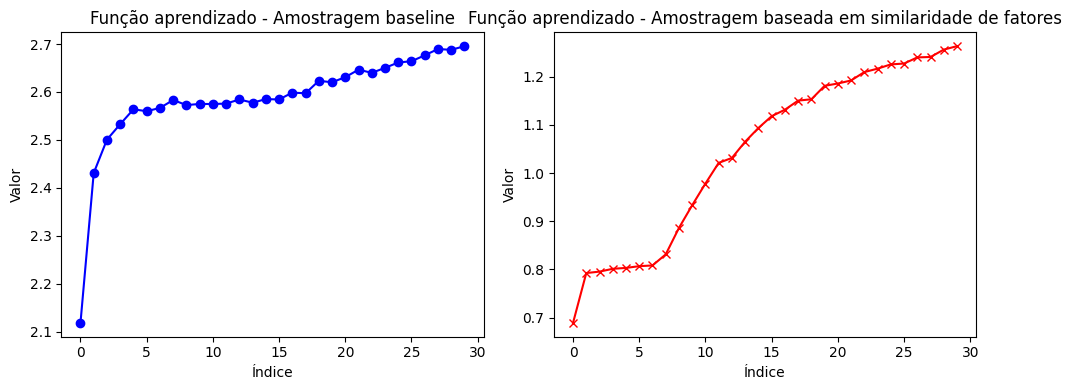

In [115]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].plot(error, color='b', marker='o')
axs[0].set_title('Função aprendizado - Amostragem baseline')
axs[0].set_xlabel('Índice')
axs[0].set_ylabel('Valor')

# Segundo gráfico (lista2)
axs[1].plot(error_fac, color='r', marker='x')
axs[1].set_title('Função aprendizado - Amostragem baseada em similaridade de fatores')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Valor')

plt.tight_layout()

plt.show()

Aparentemente o aprendizado é mais lento com amostragem baseado em similaridade de fatores, mostrando que os exemplos positivos e negativos selecionados talvez não sejam tão apropriados.  Vamos avaliar as recomendações

In [116]:
def predict(p, q, b, N=10):
    w = b.T + np.dot(p, q.T)
    ranking = []
    
    for u, user in enumerate(all_users):
        partial_ranking = list()
        candidate_items = sorted(range(len(w[u])), key=lambda k: w[u][k], reverse=True)
        
        for i in candidate_items:
            if i not in observed[user]:
                partial_ranking.append((user, i, w[u][i]))

            if len(partial_ranking) == N:
                break

        ranking += partial_ranking
        
    return pd.DataFrame(ranking, columns=['userId', 'movieId', 'score'])
    

In [117]:
baseline_predictions = predict(p, q, i_b)

In [119]:
baseline_metrics = baseline_predictions.copy()
baseline_metrics['AP'] = baseline_metrics.apply(lambda r: average_precision(r.userId,  baseline_metrics[baseline_metrics["userId"] == r.userId].sort_values(by='score', ascending=False).iloc[:10], test), axis=1)

In [118]:
variant_predictions = predict(p_fac, q_fac, i_b_fac)

In [120]:
variant_metrics = variant_predictions.copy()
variant_metrics['AP'] = variant_metrics.apply(lambda r: average_precision(r.userId,  variant_metrics[variant_metrics["userId"] == r.userId].sort_values(by='score', ascending=False).iloc[:10], test), axis=1)

In [122]:
np.mean(baseline_metrics['AP'])

0.4347932978696939

In [123]:
np.mean(variant_metrics['AP'])

0.015522617974150884

Bem pior que o baseline hehe =) Vamos tentar repetir o experimento considerando como threshold o 70-percentil das distancias, ao inves da mediana (50-percentil)

In [124]:
user_thresholds = {}
for idx, u in enumerate(user_factors):
    distances = []
    for i in item_factors:
        dist = cos(u, i)
        distances.append(dist)
    user_thresholds[idx] = np.percentile(distances, 70)

In [125]:
i_b_fac, p_fac, q_fac , error_fac = train_bprmf(train, n_factors=10, draw_func=draw_factors)

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
Iter # 19
Iter # 20
Iter # 21
Iter # 22
Iter # 23
Iter # 24
Iter # 25
Iter # 26
Iter # 27
Iter # 28
Iter # 29


In [127]:
variant_predictions_70p = predict(p_fac, q_fac, i_b_fac)

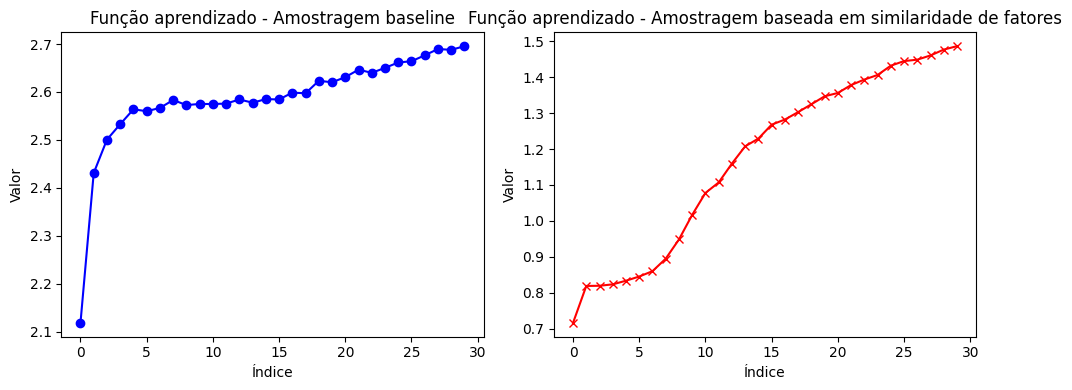

In [126]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].plot(error, color='b', marker='o')
axs[0].set_title('Função aprendizado - Amostragem baseline')
axs[0].set_xlabel('Índice')
axs[0].set_ylabel('Valor')

axs[1].plot(error_fac, color='r', marker='x')
axs[1].set_title('Função aprendizado - Amostragem baseada em similaridade de fatores')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Valor')

plt.tight_layout()

plt.show()

In [128]:
variant_metrics_70p = variant_predictions_70p.copy()
variant_metrics_70p['AP'] = variant_metrics_70p.apply(lambda r: average_precision(r.userId,  variant_metrics_70p[variant_metrics_70p["userId"] == r.userId].sort_values(by='score', ascending=False).iloc[:10], test), axis=1)

In [129]:
np.mean(variant_metrics_70p['AP'])

0.014427054260237307

O modelo realmente não parece ter aprendido. Parece que o modelo tem potencial para crescer mais, visto que a curva de aprendizado estava em franco crescimento na 30a iteração.